## Scenario 1

Non-age structured model with b~=0

* training data: (samples of) WF model with $b\in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from WF model with specific $b_i$ values 
* outcome: 1-P(neutral)

We plot the $b_i$ values on the x-axis and the 1-P(neutral ) on the y-axis and compare this to the rejection probability obtained from the Ewens-Watterson test.

In [1]:
import os
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier

In [2]:
%run ../src/dataset.py
%run ../src/augmentation.py
%run ../src/simulation.py
%run ../src/utils.py

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

models = {}

for n in (100, 500, 1000, 2000):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    data = PresimulatedDataset.load(
        "../data/scenario-1-trainset.npz", transform=transform)
    X, theta = data.dataset, data.theta
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.2, shuffle=True)
    y_train = (theta_train[:, 0].numpy() != 0).astype(int)
    y_dev = (theta_dev[:, 0].numpy() != 0).astype(int)
    
    clf = RandomForestClassifier(n_jobs=10)
    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_dev)[:, 1]
    score = roc_auc_score(y_dev, probs)
    
    models[n] = {
        "clf": clf,
        "dev score": score
    }

In [122]:
models

{100: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9299936147942278},
 500: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9585804251663678},
 1000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9610315941263765},
 2000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.9645623783380322}}

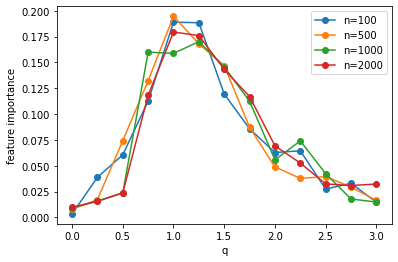

In [126]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

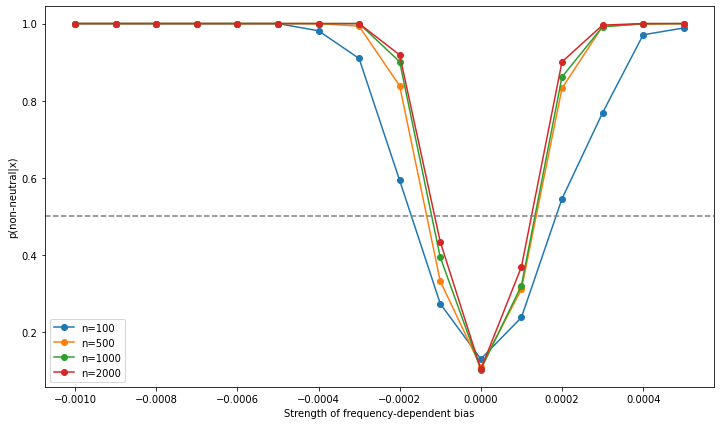

In [132]:
fig, ax = plt.subplots(figsize=(12, 7))

for i, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-1-testset.npz", transform=transform)

    X_test, theta_test = testdata.dataset, testdata.theta
    y_test = (theta_test[:, 0].numpy() != 0).astype(int)
    
    probs = models[n]["clf"].predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, probs)
    
    df = pd.DataFrame(theta_test.numpy(), columns=["b", "p_mut", "p_death", "age_max"])
    df["pred"] = probs
    df.groupby("b")["pred"].mean().plot(style='-o', ax=ax, color=f"C{i}", label=f"n={n}")
#     df.plot.scatter(x="b", y="pred", alpha=0.1, color=f"C{i}", ax=ax)
    
ax.set(ylabel="p(non-neutral|x)", xlabel="Strength of frequency-dependent bias");
ax.axhline(0.5, ls="--", color="grey")
plt.legend();

## Scenario 2

age-structured model with b=0

* training data: (samples of) age-structured model with copyThresholdHigh $\in [2,\ldots,\text{All}]$ and pDeath $\in [0.02, 0.1]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific $\text{copyThresholdHigh}_i$ values and $\text{pDeath}_i$ values
*outcome: 1-P(neutral)

As before plot the $\text{copyThresholdHigh}_i$  values on the x-axis and the 1-P(neutral) on the y-axis compare this to the rejection probability obtained from the Ewens-Watterson test (or even 3d plot with copyThresholdHigh_i values and $\text{pDeath}_i$ values on x and y axis)

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

models_2 = {}

for n in (100, 500, 1000, 2000):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    data = PresimulatedDataset.load(
        "../data/scenario-2-large-trainset.npz", transform=transform)
    X, theta = data.dataset.numpy(), data.theta.numpy()
    
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)
    X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
    y_test = (theta_test[:, 0] != 0).astype(int)
    
#     index = (theta[:, 0] >= -0.001) & (theta[:, 0] <= 0.0005)
#     X, theta = X[index], theta[index]
        
    X_train, X_dev, theta_train, theta_dev = train_test_split(
        X, theta, test_size=0.0001, shuffle=True)
    y_train = (theta_train[:, 0] != 0).astype(int)
    y_dev = (theta_dev[:, 0] != 0).astype(int)
        
    clf = xgb.XGBClassifier(
        n_estimators=300,
        eval_metric="logloss",
        use_label_encoder=False,
        n_jobs=10,
        learning_rate=0.1
    )   
        #RandomForestClassifier(n_jobs=10)

    clf.fit(X_train, y_train)

    probs = clf.predict_proba(X_test)[:, 1]
    score = roc_auc_score(y_test, probs)
    print(score)
    
    models_2[n] = {
        "clf": clf,
        "dev score": score,
        "scaler": scaler
    }

In [362]:
models_2

{100: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.859461113594566,
  'scaler': StandardScaler()},
 500: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.8735165774844198,
  'scaler': StandardScaler()},
 1000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.8629028951345058,
  'scaler': StandardScaler()},
 2000: {'clf': RandomForestClassifier(n_jobs=10),
  'dev score': 0.8715295941586857,
  'scaler': StandardScaler()}}

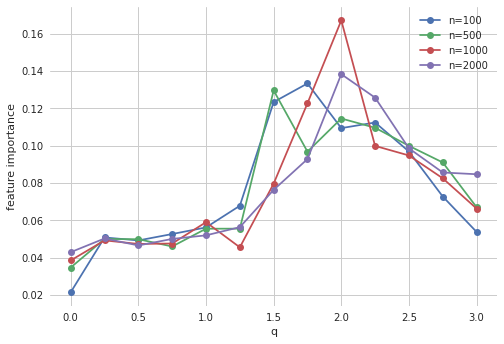

In [363]:
fig, ax = plt.subplots()

q_values = np.arange(0, 3.25, 0.25)

for i, n in enumerate((100, 500, 1000, 2000)):
    ax.plot(q_values, models_2[n]["clf"].feature_importances_, '-o', color=f"C{i}", label=f"n={n}")
ax.set(xlabel="q", ylabel="feature importance")
plt.legend()

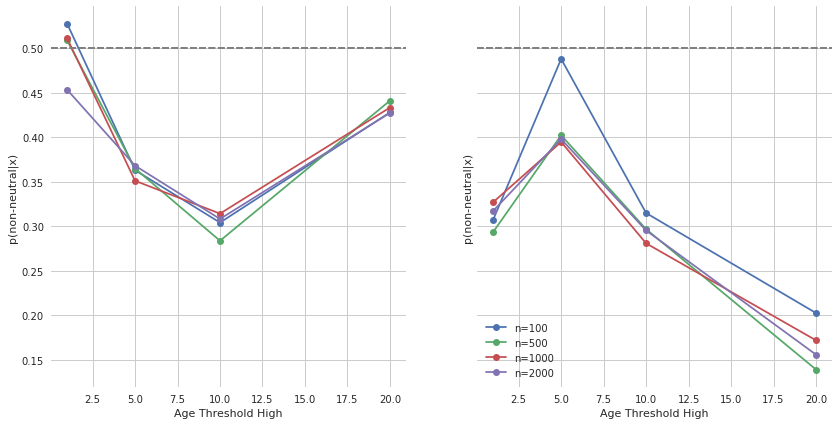

In [364]:
import pandas as pd

fig, axes = plt.subplots(ncols=2, figsize=(14, 7), sharey=True)
axes = axes.flatten()

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 0] == 0.0) & (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]
        
        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = probs
        df = df.groupby("age_max")["pred"].mean()
        values, labels = df.values, df.index
        axes[i].plot(labels, values, '-o', color=f"C{j}", label=f"n={n}")
    
        axes[i].set(ylabel="p(non-neutral|x)", xlabel="Age Threshold High");
        axes[i].axhline(0.5, ls="--", color="grey")
plt.legend();

## Scenario 3

age-structured model with $b \approx 0$

* training data: (samples of) age-structured model with copyThresholdHigh $\in[2,…,All]$ and pDeath $\in [0.02,0.1]$ and $b \in[-0.001,0.0006]$
* observed data: samples (n=50,100,500,1000,2000) from age-structured model with specific copyThresholdHigh_i values and pDeath_i values and $b_i$ values
* outcome: 1-P(neutral)

Now it probably needs to become a 3d plot with $b_i$ and copyThreshold on x- and y-axis?

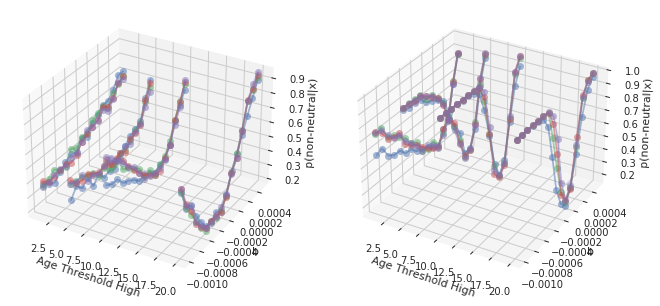

In [150]:
import pandas as pd

fig = plt.figure(figsize=(14, 7))
axes = (
    fig.add_subplot(1, 2, 1, projection='3d'), 
    fig.add_subplot(1, 2, 2, projection='3d')
)

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]

        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = probs
        for age, g in df.groupby("age_max"):
            g = g.groupby("b")["pred"].mean()
            b = g.index
            values = g.values
            axes[i].plot([age]*len(b), b, values, '-o', color=f"C{j}", alpha=0.5)
    
        axes[i].set(zlabel="p(non-neutral|x)", xlabel="Age Threshold High", ylabel="b");

The 3d plots are a little hard to read. Let's try a facetted plot:

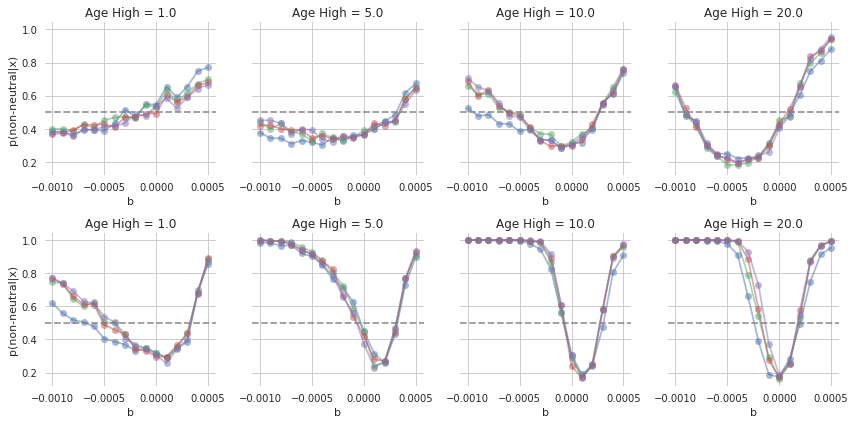

In [161]:
import pandas as pd


fig, axes = plt.subplots(ncols=4, nrows=2, sharey=True, figsize=(12, 6))

for j, n in enumerate((100, 500, 1000, 2000)):
    transform = Compose(Sampler(n=n), HillNumbers(q_step=0.25))
    testdata = PresimulatedDataset.load(
        "../data/scenario-2-testset.npz", transform=transform)

    for i, p_death in enumerate((0.02, 0.1)):

        X_test, theta_test = testdata.dataset.numpy(), testdata.theta.numpy()
        y_test = (theta_test[:, 0] != 0).astype(int)
        
        index = (theta_test[:, 2] == p_death)
        
        X_test, y_test = X_test[index], y_test[index]


        probs = models_2[n]["clf"].predict_proba(X_test)[:, 1]

        df = pd.DataFrame(theta_test[index], columns=["b", "p_mut", "p_death", "age_max"])
        df["pred"] = probs
        for k, (age, g) in enumerate(df.groupby("age_max")):
            g = g.groupby("b")["pred"].mean()
            axes[i, k].plot(g.index, g.values, '-o', color=f"C{j}", alpha=0.5)
            axes[i, k].axhline(0.5, ls="--", color="grey", alpha=0.3)
            axes[i, k].set(xlabel="$\\beta$", title=f"Age High = {age}")
    
        axes[i, 0].set(ylabel="p(non-neutral|x)")

plt.tight_layout()

Question: why is $p(death) = 0.02$ so much harder than $p(death) = 0.1$. Less variation in the statistics?